In [1]:
#Imports
import pandas as pd
import requests
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from census import Census
from projectconfig import (censuskey, googmapskey)
import gmaps
import requests
import time
from us import states


## Developing the DataFrame(s)

In [2]:
#Set CSV file locations.  May need modification if data moved to other folder.
aqi_csvlocation = '../Datasets/aqi.csv'
asthma_csvlocation = '../Datasets/asthmaER.csv'
population_csvlocation = '../Datasets/PEP_2017_PEPANNRES_with_ann.csv'

#Read the CSV's into dataframes
aqidf = pd.read_csv(aqi_csvlocation)
asthmadf = pd.read_csv(asthma_csvlocation)
populationdf = pd.read_csv(population_csvlocation)

#Pull out only the aqi data about Georgia
gaaqidf = aqidf.loc[aqidf['State']=='Georgia']

#Set indices as counties for convenience
popdf = populationdf.set_index('GEO.display-label')
asthmadf = asthmadf.set_index('County')

#Pull out a list of the counties that we are actually pursuing
countylist = gaaqidf['County'].unique()
asthmadf.head()
# countylist

,2010,2011,2012,2013,2014,2015,2016,2017
County,,,,,,,,
Appling,58,59,74,78,68,53,71,61
Atkinson,37,16,45,42,60,32,29,28
Bacon,53,40,65,51,50,45,34,40
Baker,22,13,13,26,25,33,26,24
Baldwin,255,264,406,321,300,259,323,251


In [3]:
#Remove commas and convert values to floats
#Otherwise we have Chatham County with values like 1,845

for year in np.arange(2010,2018):
    asthmadf[f'{year}'] = asthmadf[f'{year}'].str.replace(",","").astype(float)

#Saving as tempdf in order to keep from corrupting original dataframe
tempdf = asthmadf

In [4]:
#Adding new columns containing the prevalence per county per year

for year in np.arange(2010,2018):
    tempdf[f'{year} pcnt'] = [asthmadf.loc[county][f'{year}']/float(popdf.loc[f'{county} County, Georgia'][f'respop7{year}']) for county in asthmadf.index]

In [5]:
gaaqidf = gaaqidf.drop(columns='State')
gaaqidf = gaaqidf.set_index('County')

In [6]:
#Next step: Keep days{year}, gooddays{year}, max{year}, median{year}, 90pcnt{year}

splitaqidf = pd.DataFrame(index=countylist)

for year in np.arange(2010,2018):
    splitaqidf[f'Total Days ({year})'] = gaaqidf.loc[gaaqidf['Year']==year]['Days with AQI']
    splitaqidf[f'Good Days ({year})'] = gaaqidf.loc[gaaqidf['Year']==year]['Good Days']
    splitaqidf[f'Max AQI ({year})'] = gaaqidf.loc[gaaqidf['Year']==year]['Max AQI']
    splitaqidf[f'90th Percentile AQI ({year})'] = gaaqidf.loc[gaaqidf['Year']==year]['90th Percentile AQI']
    splitaqidf[f'Median AQI ({year})'] = gaaqidf.loc[gaaqidf['Year']==year]['Median AQI']
    splitaqidf[f'Days PM2.5 ({year})'] = gaaqidf.loc[gaaqidf['Year']==year]['Days PM2.5']
    splitaqidf[f'Days PM10 ({year})'] = gaaqidf.loc[gaaqidf['Year']==year]['Days PM10']
    
    
splitaqidf.head()

,Total Days (2010),Good Days (2010),Max AQI (2010),90th Percentile AQI (2010),Median AQI (2010),Days PM2.5 (2010),Days PM10 (2010),Total Days (2011),Good Days (2011),Max AQI (2011),...,Median AQI (2016),Days PM2.5 (2016),Days PM10 (2016),Total Days (2017),Good Days (2017),Max AQI (2017),90th Percentile AQI (2017),Median AQI (2017),Days PM2.5 (2017),Days PM10 (2017)
Bibb,364.0,160.0,133.0,76.0,53.0,289.0,1.0,364,174,151,...,42,219,0,365.0,284.0,93.0,58.0,40.0,202.0,0.0
Charlton,119.0,107.0,67.0,51.0,30.0,119.0,0.0,115,93,89,...,23,117,0,47.0,43.0,89.0,47.0,25.0,47.0,0.0
Chatham,365.0,183.0,107.0,74.0,50.0,178.0,0.0,365,176,160,...,39,191,0,365.0,289.0,84.0,57.0,38.0,230.0,0.0
Chattooga,264.0,203.0,97.0,71.0,41.0,0.0,22.0,256,202,115,...,42,0,0,240.0,232.0,64.0,45.0,36.0,0.0,0.0
Clarke,365.0,205.0,147.0,77.0,46.0,228.0,0.0,365,212,126,...,40,171,0,360.0,314.0,97.0,53.0,38.0,172.0,0.0


In [7]:
mergeddf = pd.merge(splitaqidf,tempdf,left_index=True,right_index=True)

In [8]:
mergeddf = mergeddf.drop(columns=['2010','2011','2012','2013','2014','2015','2016','2017'])
mergeddf.head()
# mergeddf.to_csv("./mergeddf.csv")

,Total Days (2010),Good Days (2010),Max AQI (2010),90th Percentile AQI (2010),Median AQI (2010),Days PM2.5 (2010),Days PM10 (2010),Total Days (2011),Good Days (2011),Max AQI (2011),...,Days PM2.5 (2017),Days PM10 (2017),2010 pcnt,2011 pcnt,2012 pcnt,2013 pcnt,2014 pcnt,2015 pcnt,2016 pcnt,2017 pcnt
Bibb,364.0,160.0,133.0,76.0,53.0,289.0,1.0,364,174,151,...,202.0,0.0,0.006187,0.005806,0.006492,0.006345,0.006599,0.006673,0.008642,0.009263
Charlton,119.0,107.0,67.0,51.0,30.0,119.0,0.0,115,93,89,...,47.0,0.0,0.003968,0.003343,0.002919,0.002896,0.002071,0.001744,0.001490,0.001416
Chatham,365.0,183.0,107.0,74.0,50.0,178.0,0.0,365,176,160,...,230.0,0.0,0.007015,0.007036,0.008022,0.007551,0.006519,0.005861,0.006179,0.006296
Chattooga,264.0,203.0,97.0,71.0,41.0,0.0,22.0,256,202,115,...,0.0,0.0,0.002736,0.002298,0.003747,0.003274,0.004023,0.002571,0.003181,0.002301
Clarke,365.0,205.0,147.0,77.0,46.0,228.0,0.0,365,212,126,...,172.0,0.0,0.003490,0.003749,0.004254,0.004649,0.004548,0.004480,0.004879,0.004651


In [9]:
mergeddf.keys()

Index(['Total Days (2010)', 'Good Days (2010)', 'Max AQI (2010)',
       '90th Percentile AQI (2010)', 'Median AQI (2010)', 'Days PM2.5 (2010)',
       'Days PM10 (2010)', 'Total Days (2011)', 'Good Days (2011)',
       'Max AQI (2011)', '90th Percentile AQI (2011)', 'Median AQI (2011)',
       'Days PM2.5 (2011)', 'Days PM10 (2011)', 'Total Days (2012)',
       'Good Days (2012)', 'Max AQI (2012)', '90th Percentile AQI (2012)',
       'Median AQI (2012)', 'Days PM2.5 (2012)', 'Days PM10 (2012)',
       'Total Days (2013)', 'Good Days (2013)', 'Max AQI (2013)',
       '90th Percentile AQI (2013)', 'Median AQI (2013)', 'Days PM2.5 (2013)',
       'Days PM10 (2013)', 'Total Days (2014)', 'Good Days (2014)',
       'Max AQI (2014)', '90th Percentile AQI (2014)', 'Median AQI (2014)',
       'Days PM2.5 (2014)', 'Days PM10 (2014)', 'Total Days (2015)',
       'Good Days (2015)', 'Max AQI (2015)', '90th Percentile AQI (2015)',
       'Median AQI (2015)', 'Days PM2.5 (2015)', 'Days PM10 (2015

## Plotting

In [10]:
xaxis2010 = mergeddf["Median AQI (2010)"]
yaxis2010 = mergeddf["2010 pcnt"]

xaxis2011 = mergeddf["Median AQI (2011)"]
yaxis2011 = mergeddf["2011 pcnt"]

xaxis2012 = mergeddf["Median AQI (2012)"]
yaxis2012 = mergeddf["2012 pcnt"]

xaxis2013 = mergeddf["Median AQI (2013)"]
yaxis2013 = mergeddf["2013 pcnt"]

xaxis2014 = mergeddf["Median AQI (2014)"]
yaxis2014 = mergeddf["2014 pcnt"]

xaxis2015 = mergeddf["Median AQI (2015)"]
yaxis2015 = mergeddf["2015 pcnt"]

xaxis2016 = mergeddf["Median AQI (2016)"]
yaxis2016 = mergeddf["2016 pcnt"]

xaxis2017 = mergeddf["Median AQI (2017)"]
yaxis2017 = mergeddf["2017 pcnt"]

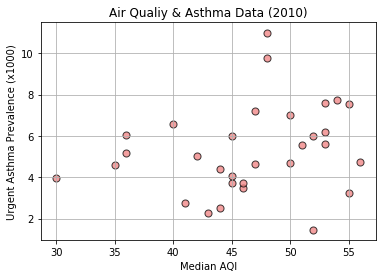

In [11]:
plt.scatter(xaxis2010, yaxis2010*1000, s = 50, marker="o", facecolors="LightCoral", edgecolors="black", alpha = .75)
plt.grid(b=True, which='major', axis='both')
x_label = plt.xlabel("Median AQI")
y_label = plt.ylabel("Urgent Asthma Prevalence (x1000)")
plt.title("Air Qualiy & Asthma Data (2010)")
plt.savefig("../Images/air_asthma_plot_2010.png")

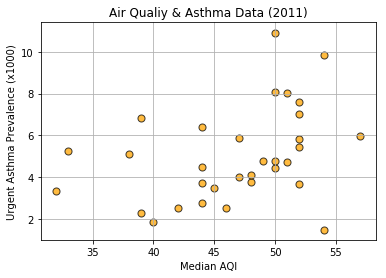

In [12]:
plt.scatter(xaxis2011, yaxis2011*1000, s = 50, marker="o", facecolors="Orange", edgecolors="black", alpha = .75)
plt.grid(b=True, which='major', axis='both')
x_label = plt.xlabel("Median AQI")
y_label = plt.ylabel("Urgent Asthma Prevalence (x1000)")
plt.title("Air Qualiy & Asthma Data (2011)")
plt.savefig("../Images/air_asthma_plot_2011.png")

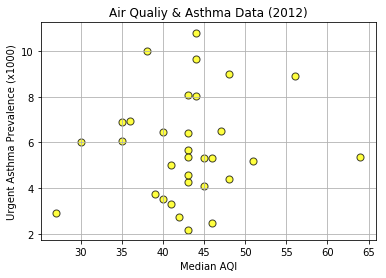

In [13]:
plt.scatter(xaxis2012, yaxis2012*1000, s = 50, marker="o", facecolors="Yellow", edgecolors="black", alpha = .75)
plt.grid(b=True, which='major', axis='both')
x_label = plt.xlabel("Median AQI")
y_label = plt.ylabel("Urgent Asthma Prevalence (x1000)")
plt.title("Air Qualiy & Asthma Data (2012)")
plt.savefig("../Images/air_asthma_plot_2012.png")

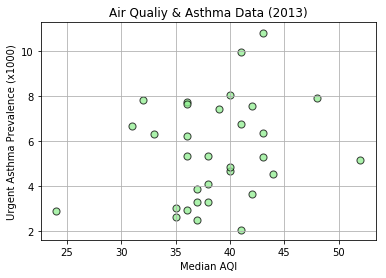

In [14]:
plt.scatter(xaxis2013, yaxis2013*1000, s = 50, marker="o", facecolors="LightGreen", edgecolors="black", alpha = .75)
plt.grid(b=True, which='major', axis='both')
x_label = plt.xlabel("Median AQI")
y_label = plt.ylabel("Urgent Asthma Prevalence (x1000)")
plt.title("Air Qualiy & Asthma Data (2013)")
plt.savefig("../Images/air_asthma_plot_2013.png")

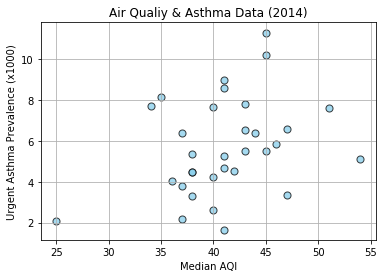

In [15]:
plt.scatter(xaxis2014, yaxis2014*1000, s = 50, marker="o", facecolors="SkyBlue", edgecolors="black", alpha = .75)
plt.grid(b=True, which='major', axis='both')
x_label = plt.xlabel("Median AQI")
y_label = plt.ylabel("Urgent Asthma Prevalence (x1000)")
plt.title("Air Qualiy & Asthma Data (2014)")
plt.savefig("../Images/air_asthma_plot_2014.png")

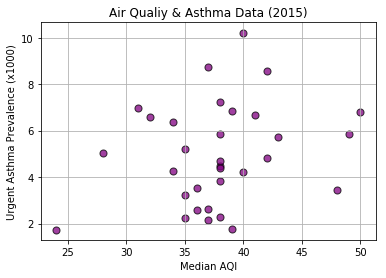

In [16]:
plt.scatter(xaxis2015, yaxis2015*1000, s = 50, marker="o", facecolors="Purple", edgecolors="black", alpha = .75)
plt.grid(b=True, which='major', axis='both')
x_label = plt.xlabel("Median AQI")
y_label = plt.ylabel("Urgent Asthma Prevalence (x1000)")
plt.title("Air Qualiy & Asthma Data (2015)")
plt.savefig("../Images/air_asthma_plot_2015.png")

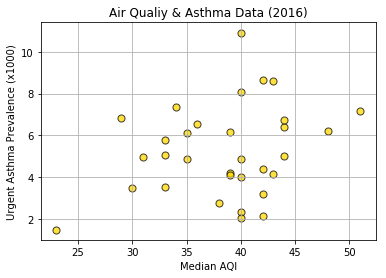

In [17]:
plt.scatter(xaxis2016, yaxis2016*1000, s = 50, marker="o", facecolors="Gold", edgecolors="black", alpha = .75)
plt.grid(b=True, which='major', axis='both')
x_label = plt.xlabel("Median AQI")
y_label = plt.ylabel("Urgent Asthma Prevalence (x1000)")
plt.title("Air Qualiy & Asthma Data (2016)")
plt.savefig("../Images/air_asthma_plot_2016.png")

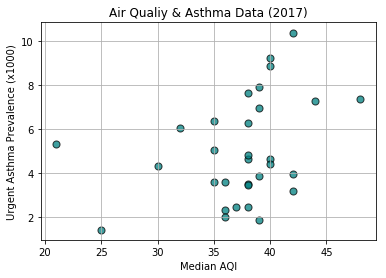

In [18]:
plt.scatter(xaxis2017, yaxis2017*1000, s = 50, marker="o", facecolors="Teal", edgecolors="black", alpha = .75)
plt.grid(b=True, which='major', axis='both')
x_label = plt.xlabel("Median AQI")
y_label = plt.ylabel("Urgent Asthma Prevalence (x1000)")
plt.title("Air Qualiy & Asthma Data (2017)")
plt.savefig("../Images/air_asthma_plot_2017.png")

Input the county name to display a summary. Bibb
                             Bibb
Total Days (2010)           364.0
Good Days (2010)            160.0
Max AQI (2010)              133.0
90th Percentile AQI (2010)   76.0
Median AQI (2010)            53.0


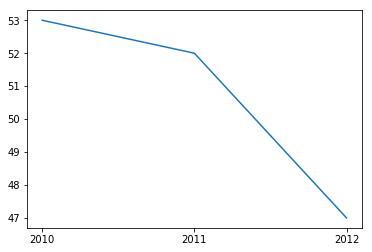

Search for another county? (y or n). n


In [19]:
researching = "y"
while researching == "y":
    user_county = input("Input the county name to display a summary. ")
    if user_county in countylist:
        countydata = pd.DataFrame(mergeddf.loc[user_county])
        years = ["2010", "2011", "2012"]
        medaqi_year = pd.Series(countydata[user_county].loc[["Median AQI (2010)", "Median AQI (2011)", "Median AQI (2012)"]])
        plt.figure()

        print(countydata.head())
        plt.plot(years, medaqi_year)
        plt.show()
        researching = input("Search for another county? (y or n). ")

    else:
        print("County data not found.")
        researching = input("Search for another county? (y or n). ")

In [20]:
aqi90 = mergeddf[["90th Percentile AQI (2010)", "90th Percentile AQI (2011)", "90th Percentile AQI (2012)", "90th Percentile AQI (2013)", "90th Percentile AQI (2014)", "90th Percentile AQI (2015)", "90th Percentile AQI (2016)", "90th Percentile AQI (2017)"]]
aqi90.head()

,90th Percentile AQI (2010),90th Percentile AQI (2011),90th Percentile AQI (2012),90th Percentile AQI (2013),90th Percentile AQI (2014),90th Percentile AQI (2015),90th Percentile AQI (2016),90th Percentile AQI (2017)
Bibb,76.0,87,69,61,64,60,63,58.0
Charlton,51.0,57,42,41,48,39,43,47.0
Chatham,74.0,81,68,69,60,57,55,57.0
Chattooga,71.0,61,61,46,49,49,51,45.0
Clarke,77.0,81,67,60,61,54,61,53.0


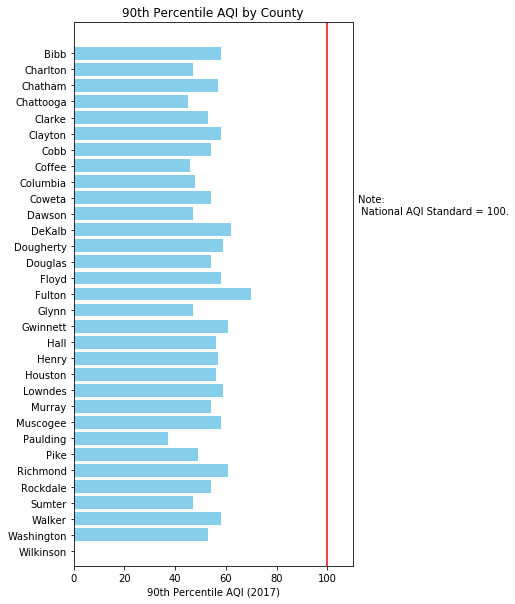

<Figure size 432x288 with 0 Axes>

In [21]:
fig, ax = plt.subplots(figsize=(5,10))
yaxis2017 = np.arange(len(countylist))
aqi902017 = pd.Series(aqi90["90th Percentile AQI (2017)"])

ax.barh(yaxis2017, aqi902017, align='center',
        color='skyblue', ecolor='black')
ax.set_yticks(yaxis2017)
ax.set_yticklabels(countylist)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('90th Percentile AQI (2017)')
ax.set_title('90th Percentile AQI by County')
ax.set_xlim([0, 110])
ax.axvline(x=100, ymin=0, ymax=1, color="red")
plt.text(112, 10, "Note:\n National AQI Standard = 100.")

plt.show()
plt.savefig("../Images/county_vs_national_2017.png")

## Google Map API Call

In [22]:
# Census API Key
c = Census(censuskey)
gmaps.configure(api_key = googmapskey)

In [23]:
# Create dataframe
stateasthma_df = pd.DataFrame(pd.read_csv("../Datasets/usstates.csv"))
stateasthma_df = stateasthma_df.dropna()
stateasthma_df.sort_values("Percent with Current Asthma")
stateasthma_df.head()

,State or Territory,Number with Current Asthma,Percent with Current Asthma,Latitude,Longitude
0,Alabama,"370,128",9.9,32.806671,-86.791130
1,Alaska,"50,792",9.2,61.370716,-152.404419
2,Arizona,"479,791",9.3,33.729759,-111.431221
3,Arkansas,"226,691",10.1,34.969704,-92.373123
4,California,"2,290,491",7.7,36.116203,-119.681564


In [24]:
statecrds = stateasthma_df[["Latitude", "Longitude"]]
statecrds.head()

,Latitude,Longitude
0,32.806671,-86.791130
1,61.370716,-152.404419
2,33.729759,-111.431221
3,34.969704,-92.373123
4,36.116203,-119.681564


In [25]:
asthmaprev = stateasthma_df["Percent with Current Asthma"].astype(float)
# asthmaprev

In [26]:
# Plot Heatmap
asthmafig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(statecrds, weights=asthmaprev,dissipating=False, max_intensity=10, point_radius=1)


# Add layer
asthmafig.add_layer(heat_layer)

In [27]:
asthmafig

Figure(layout=FigureLayout(height='420px'))

In [28]:
airbyloc = pd.read_csv("../Datasets/airbyloc.csv")
airbyloc.head()

,County,90th Percentile AQI (2017),Lat,Lng
0,Bibb,58,32.827949,-83.595066
1,Charlton,47,30.855314,-82.027252
2,Chatham,57,32.001601,-81.0831676
3,Chattooga,45,34.392073,-85.417428
4,Clarke,53,33.950115,-83.3832137


In [29]:
aqi2017 = airbyloc["90th Percentile AQI (2017)"].astype(float)

countycrds = airbyloc[["Lat", "Lng"]].astype(float)
countycrds.head()


,Lat,Lng
0,32.827949,-83.595066
1,30.855314,-82.027252
2,32.001601,-81.083168
3,34.392073,-85.417428
4,33.950115,-83.383214


In [30]:
# Plot Heatmap
airfig = gmaps.figure()

# Create heat layer
air_heat_layer = gmaps.heatmap_layer(countycrds, weights=(aqi2017 / 100),dissipating=False, max_intensity=10, point_radius=1)


# Add layer
airfig.add_layer(air_heat_layer)

In [31]:
airfig

Figure(layout=FigureLayout(height='420px'))

## Exploring Rural vs Urban Counties

In [32]:
#Adding new columns containing the prevalence per county per year for urban vs rural
rural_asthma_csvlocation = '../Datasets/rural_asthmaER.csv'
urban_asthma_csvlocation = '../Datasets/urban_asthmaER.csv'
rural_asthmadf = pd.read_csv(rural_asthma_csvlocation)
urban_asthmadf = pd.read_csv(urban_asthma_csvlocation)

for year in np.arange(2010,2018):
    #rural_asthmadf[f'{year}'] = rural_asthmadf[f'{year}'].str.replace(",","").astype(float)
    urban_asthmadf[f'{year}'] = urban_asthmadf[f'{year}'].str.replace(",","").astype(float)
    rural_asthmadf[f'{year} pcnt'] = [rural_asthmadf.loc[county][f'{year}']/float(popdf.loc[f'{county} County, Georgia'][f'respop7{year}']) for county in rural_asthmadf.index]
    urban_asthmadf[f'{year} pcnt'] = [urban_asthmadf.loc[county][f'{year}']/float(popdf.loc[f'{county} County, Georgia'][f'respop7{year}']) for county in urban_asthmadf.index]

KeyError: 'the label [0 County, Georgia] is not in the [index]'

In [ ]:
stats.ttest_ind(rural_asthmadf['2010 pcnt'],urban_asthmadf['2010 pcnt'],equal_var=False)

In [ ]:
rural_asthmadf['2010 pcnt'].mean(),rural_asthmadf['2010 pcnt'].sem(),urban_asthmadf['2010 pcnt'].mean(),urban_asthmadf['2010 pcnt'].sem()

In [ ]:
#Is the ER Prevalence for asthma significantly different between rural and urban counties?

pvals = []
for year in np.arange(2010,2018):
    s,p = stats.ttest_ind(rural_asthmadf[f'{year} pcnt'],urban_asthmadf[f'{year} pcnt'],equal_var=False)
    pvals.append(p)
pvals
#Not really, no.  2013 they appeared like they might be, but not different enough to reject the null hypothesis

In [ ]:
ruralcountylist = []
urbancountylist = []
for county in countylist:
    if county in urban_asthmadf.index:
        urbancountylist.append(county)
    elif county in rural_asthmadf.index:
        ruralcountylist.append(county)

In [ ]:
mergeddf.loc[ruralcountylist]

In [ ]:
p
f'{p:1.6f}'

In [ ]:
for i in np.arange(1,9):
    plt.figure()
    plt.scatter(mergeddf[f'Good Days ({2009+i})'].loc[urbancountylist]/mergeddf.loc[urbancountylist][f'Total Days ({2009+i})'],mergeddf.loc[urbancountylist][f'{2009+i} pcnt']*100000, c='r')
    plt.scatter(mergeddf[f'Good Days ({2009+i})'].loc[ruralcountylist]/mergeddf.loc[ruralcountylist][f'Total Days ({2009+i})'],mergeddf.loc[ruralcountylist][f'{2009+i} pcnt']*100000, c='b')
    plt.title(f'{2009+i} Asthma ER visits vs Air Quality')
    m,b,r,p,_ = stats.linregress(mergeddf[f'Good Days ({2009+i})'].loc[np.isnan(mergeddf[f'Good Days ({2009+i})']) == False] /mergeddf[f'Total Days ({2009+i})'].loc[np.isnan(mergeddf[f'Good Days ({2009+i})']) == False],mergeddf[f'{2009+i} pcnt'].loc[np.isnan(mergeddf[f'Good Days ({2009+i})']) == False]*100000)
    xmin, xmax = min(mergeddf[f'Good Days ({2009+i})']/mergeddf[f'Total Days ({2009+i})']), max(mergeddf[f'Good Days ({2009+i})']/mergeddf[f'Total Days ({2009+i})'])
    plt.plot([xmin,xmax],[xmin*m + b, xmax*m+b])
    plt.legend([f'Best fit\np={p:1.6f}\nr={r:1.6f}\nslope={m:.2f}','Urban','Rural'])
    plt.xlabel('Ratio of days with "good" air quality')
    plt.ylabel(r'$\dfrac{ER Visits\times 100000}{Population}$')
    plt.savefig(f'../Images/gooddays_vs_ervisits_{2009+i}.png',bbox_inches='tight')
    plt.show()

In [ ]:
for i in np.arange(1,9):
    plt.figure()
    plt.scatter(mergeddf[f'Days PM2.5 ({2009+i})'].loc[urbancountylist]/mergeddf.loc[urbancountylist][f'Total Days ({2009+i})'],mergeddf.loc[urbancountylist][f'{2009+i} pcnt']*100000, c='r')
    plt.scatter(mergeddf[f'Days PM2.5 ({2009+i})'].loc[ruralcountylist]/mergeddf.loc[ruralcountylist][f'Total Days ({2009+i})'],mergeddf.loc[ruralcountylist][f'{2009+i} pcnt']*100000, c='b')
    plt.title(f'{2009+i} Asthma ER visits vs Days With High PM2.5')
    m,b,r,p,_ = stats.linregress(mergeddf[f'Days PM2.5 ({2009+i})'].loc[np.isnan(mergeddf[f'Days PM2.5 ({2009+i})']) == False] /mergeddf[f'Total Days ({2009+i})'].loc[np.isnan(mergeddf[f'Days PM2.5 ({2009+i})']) == False],mergeddf[f'{2009+i} pcnt'].loc[np.isnan(mergeddf[f'Days PM2.5 ({2009+i})']) == False]*100000)
    xmin, xmax = min(mergeddf[f'Days PM2.5 ({2009+i})']/mergeddf[f'Total Days ({2009+i})']), max(mergeddf[f'Days PM2.5 ({2009+i})']/mergeddf[f'Total Days ({2009+i})'])
    plt.plot([xmin,xmax],[xmin*m + b, xmax*m+b])
    plt.legend([f'Best fit\np={p:1.6f}\nr={r:1.6f}\nslope={m:.2f}','Urban','Rural'])
    plt.xlabel('Ratio of days with high partical matter count')
    plt.ylabel(r'$\dfrac{ER Visits \times 100000}{Population}$')
    plt.savefig(f'../Images/dayspm25_vs_ervisits_{2009+i}.png',bbox_inches='tight')
    plt.show()

In [ ]:
for i in np.arange(1,9):
    plt.figure()
    plt.scatter(mergeddf[f'Days Ozone ({2009+i})'].loc[urbancountylist]/mergeddf.loc[urbancountylist][f'Total Days ({2009+i})'],mergeddf.loc[urbancountylist][f'{2009+i} pcnt']*100000, c='r')
    plt.scatter(mergeddf[f'Days Ozone ({2009+i})'].loc[ruralcountylist]/mergeddf.loc[ruralcountylist][f'Total Days ({2009+i})'],mergeddf.loc[ruralcountylist][f'{2009+i} pcnt']*100000, c='b')
    plt.title(f'{2009+i} Asthma ER visits vs Days With High Ozone')
    m,b,r,p,_ = stats.linregress(mergeddf[f'Days Ozone ({2009+i})'].loc[np.isnan(mergeddf[f'Days Ozone ({2009+i})']) == False] /mergeddf[f'Total Days ({2009+i})'].loc[np.isnan(mergeddf[f'Days Ozone ({2009+i})']) == False],mergeddf[f'{2009+i} pcnt'].loc[np.isnan(mergeddf[f'Days Ozone ({2009+i})']) == False]*100000)
    xmin, xmax = min(mergeddf[f'Days Ozone ({2009+i})']/mergeddf[f'Total Days ({2009+i})']), max(mergeddf[f'Days Ozone ({2009+i})']/mergeddf[f'Total Days ({2009+i})'])
    plt.plot([xmin,xmax],[xmin*m + b, xmax*m+b])
    plt.legend([f'Best fit\np={p:1.6f}\nr={r:1.6f}\nslope={m:.2f}','Urban','Rural'])
    plt.xlabel('Ratio of days with high ozone count')
    plt.ylabel(r'$\dfrac{ER Visits \times 100000}{Population}$')
    plt.savefig(f'../Images/ozone_vs_ervisits_{2009+i}.png',bbox_inches='tight')
    plt.show()

In [ ]:
for i in np.arange(1,9):
    plt.figure()
    plt.scatter(mergeddf[f'Days PM10 ({2009+i})'].loc[urbancountylist]/mergeddf.loc[urbancountylist][f'Total Days ({2009+i})'],mergeddf.loc[urbancountylist][f'{2009+i} pcnt']*100000, c='r')
    plt.scatter(mergeddf[f'Days PM10 ({2009+i})'].loc[ruralcountylist]/mergeddf.loc[ruralcountylist][f'Total Days ({2009+i})'],mergeddf.loc[ruralcountylist][f'{2009+i} pcnt']*100000, c='b')
    plt.title(f'{2009+i} Asthma ER visits vs Days With High PM10')
    m,b,r,p,_ = stats.linregress(mergeddf[f'Days PM10 ({2009+i})'].loc[np.isnan(mergeddf[f'Days PM10 ({2009+i})']) == False] /mergeddf[f'Total Days ({2009+i})'].loc[np.isnan(mergeddf[f'Days PM10 ({2009+i})']) == False],mergeddf[f'{2009+i} pcnt'].loc[np.isnan(mergeddf[f'Days PM10 ({2009+i})']) == False]*100000)
    xmin, xmax = min(mergeddf[f'Days PM10 ({2009+i})']/mergeddf[f'Total Days ({2009+i})']), max(mergeddf[f'Days PM10 ({2009+i})']/mergeddf[f'Total Days ({2009+i})'])
    plt.plot([xmin,xmax],[xmin*m + b, xmax*m+b])
    plt.legend([f'Best fit\np={p:1.6f}\nr={r:1.6f}\nslope={m:.2f}','Urban','Rural'])
    plt.xlabel('Ratio of days with high PM10 count')
    plt.ylabel(r'$\dfrac{ER Visits \times 100000}{Population}$')
    plt.savefig(f'../Images/dayspm10_vs_ervisits_{2009+i}.png',bbox_inches='tight')
    plt.show()


In [ ]:
#Is the air quality of rural counties really significantly different than that of urban counties?

pvals = []
for i in np.arange(2010,2018):
    s,p = stats.ttest_ind(mergeddf.loc[ruralcountylist][f'Median AQI ({i})'].dropna(),mergeddf.loc[urbancountylist][f'Median AQI ({i})'].dropna())
    pvals.append(p)
pvals
#Yes!